# Tweets and Hashtag Analysis from Twitter

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# import necessary packages
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#packages for text mining and NLP
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.porter import *
from wordcloud import WordCloud

In [3]:
# using tweepy to extract tweets
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


In [4]:
#import tweepy and AuthHandler
import tweepy
from tweepy import OAuthHandler

In [5]:
# due to privacy concern the following keys have been replaced with dots, these can be obtained by applying for developer accnt
consumer_key = '............'
consumer_secret = '..........'
access_token = '.............'
access_token_secret = '............'

In [6]:
# api authorisation
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [7]:
#fetching 200 tweets related to pongal (festival)
fet_tw = tweepy.Cursor(api.search, q='pongal').items(200)

In [8]:
# creating a dataframe of tweets fetched
tw = []
for t in fet_tw:
    tw.append(t.text)

tweet_df = pd.DataFrame({'Tweet':tw})

In [9]:
tweet_df.head()

,Tweet
0,RT @sachin_rt: Sending warm wishes to everyone...
1,"RT @HumansofHyd: ""The true celebration of Sank..."
2,RT @Samanthaprabhu2: Happy Pongal / Sankranti ...
3,RT @soundaryaarajni: Wishing you all a very ha...
4,RT @BOIndiaIntl: CHENNAI - Pongal Top 5 Bookin...


In [10]:
# udf for removing desired pattern from tweets / cleaning tweets

stopeng = stopwords.words('english')     # stopwords taken from NLTK

def tweet_cleaner(t):
    
    # user mention removal
    t = re.sub(r'@[\w]*', ' ', t)
    
    # URL removal
    t = re.sub(r'http\S+', ' ', t)
    
    # email removal
    t = re.sub(r'\S+@\S+', ' ', t)
    
    # numbers, spl chars removal
    t = re.sub(r'[^a-zA-Z#]', ' ', t)
    
    # space stripping, removing double/triple spaces and RT(means retweeted)
    t = t.strip()
    t = re.sub(r"  "," ",t)
    t = re.sub(r"   "," ",t)
    t = re.sub(r'RT', '',t)
    
    # lowercase the tweets
    t = t.lower()
    
    #stopwords removal (stopwords taken from NLTK lib)
    t = ' '.join(c for c in t.split() if c not in stopeng)
    
    return t

In [11]:
# sending tweets to UDF for cleaning
clean = []
clean.extend(tweet_df.Tweet.apply(tweet_cleaner))

In [12]:
# create separate clean tweets column
tweet_df['Clean_tweet'] = clean

In [13]:
# performing stemming using porter stemmer
stemmer = PorterStemmer()
token = tweet_df['Clean_tweet'].apply(lambda t : t.split())  #tokenizing the tweets, stemming works on tokens
token = token.apply(lambda t : [stemmer.stem(i) for i in t])

In [14]:
token[0:10] #first 10 tokenized tweets

0    [send, warm, wish, everyon, onset, harvest, se...
1    [true, celebr, sankranthi, take, place, villag...
2    [happi, pongal, sankranti, god, bless, famili,...
3    [wish, happi, pongal, ador, husband, amp, abso...
4    [chennai, pongal, top, book, #darbar, jan, #ra...
5    [happi, sakranti, pongal, magh, bihu, celebr, ...
6     [happi, pongal, sankranthi, lohri, bihu, famili]
7                           [heartiest, pongal, greet]
8    [pogal, mean, mother, pongal, one, month, tami...
9                                      [happi, pongal]
Name: Clean_tweet, dtype: object

In [15]:
for i in range(len(token)):
    token[i] = ' '.join(token[i])
    
tweet_df['Clean_tweet'] = token

In [16]:
tweet_df.tail()   # I have not removed hashtags, as it'll be required to see what all is trending in twitter

,Tweet,Clean_tweet
195,RT @JSPLCorporate: Sending warm wishes to ever...,send warm wish everyon auspici occas #bihu #ma...
196,RT @SingamMemes: Wishing you a very Happy pong...,wish happi pongal folk #sooraraipottru #vaadiv...
197,@SuryahSG @mkstalin Where is @mkstalin @arival...,eat pongal
198,Enjoy the spirit of Pongal and make the day wo...,enjoy spirit pongal make day wonder happi pong...
199,RT @narendramodi: Greetings on Pongal! https:/...,greet pongal


In [17]:
# UDF for sentiment analysis
def tweet_senti(t):
    anal_tweet = TextBlob(t)
    if anal_tweet.sentiment.polarity>0:
        return 'positive'
    elif anal_tweet.sentiment.polarity<0:
        return 'negative'
    else:
        return 'neutral'

In [18]:
tweet_df['Sentiment'] = tweet_df['Clean_tweet'].apply(tweet_senti)

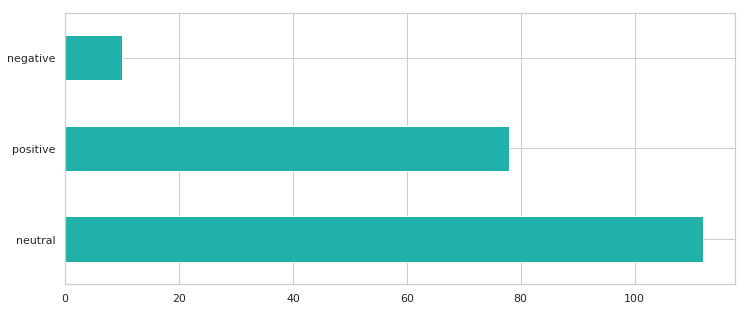

In [19]:
sns.set(style='whitegrid')
tweet_df.Sentiment.value_counts().plot.barh(figsize=(12,5), color='lightseagreen')

**As seen from above plot**
* Majority of the tweets fall under "neutral", followed by "positive"
* Since the tweets we extracted were of pongal festival, most tweets are good wishes, hence positive tweets is more compared to negative

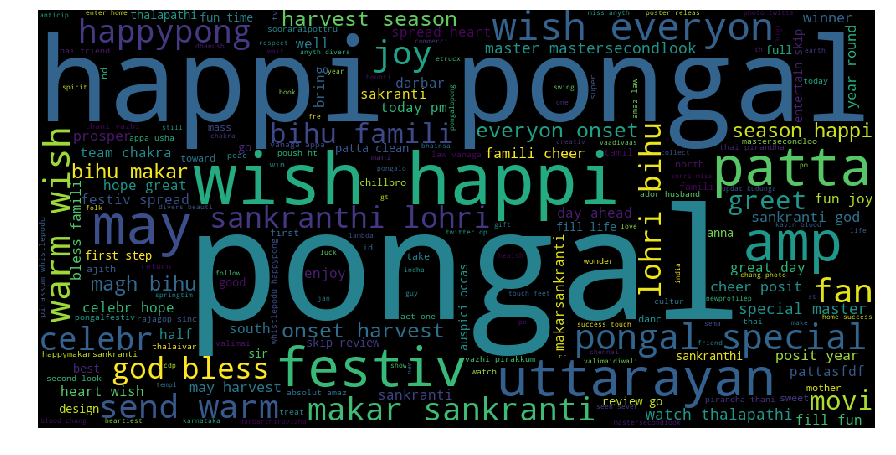

In [20]:
# creating word cloud from the tweets
all_words = ' '.join(t for t in tweet_df['Clean_tweet'])
wc = WordCloud(width = 1000, height=500, background_color='black').generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

**From the above word cloud we can conclude that**
* Most tweets were related to and contained the word "pongal", pongal wishes
* there are tweets related to Uttarayan - kite flying festival of Ahmedabad
* tweets related to harvest festivals - makar sakranthi, bihu etc.
* tweets related to movies, actors - such as "pattas", "thalapathy" etc.

In [21]:
# UDF for extracting hashtag words
def hasher(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i) # every hashtag is preceded by "#" symbol immediately followed by word characters
        hashtags.append(ht)

    return hashtags

In [22]:
tags = hasher(tweet_df['Clean_tweet'])
tags = sum(tags,[])  # for flattening out the list

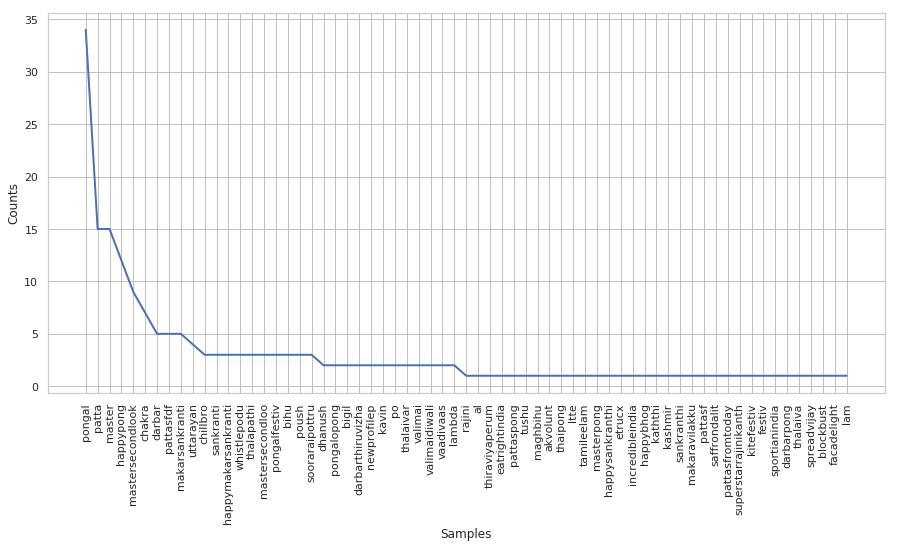

In [23]:
# using NLTK frequency distribution to analyse hashtag word occurences
tag_dist = FreqDist(tags)
plt.figure(figsize=(15,7))
tag_dist.plot()

**From the above freq. distribution we can analyse what all is trending in twitter**
* The top hashtag was "pongal" for pongal wishes
* this was followed by "pattas" - movie starring actor Dhanush released on pongal
* next trending was "master" - movie starring actor Vijay, its poster was released on pongal day
* we can also see "darbar" - a rajnikanth movie released recently was still trending

* Thank You
    * ~ C Varun ~